In [1]:
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib.ticker import FormatStrFormatter

pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
#CONSTANTS

# to do: change the rates so that there are company specific values as well (for 2019, need Via rates), maybe store in a dataframe

NON_WAV_PER_MILE_22 = 1.161
NON_WAV_PER_MIN_22 = 0.529

WAV_PER_MILE_22 = 1.504
WAV_PER_MIN_22 = 0.529

OUT_CITY_NON_WAV_PER_MILE_22 = 1.348
OUT_CITY_WAV_PER_MILE_22 = 1.746
OUT_CITY_PER_MIN_22 = 0.613


NON_WAV_PER_MILE_19 = 1.088
NON_WAV_PER_MIN_19 = 0.495

WAV_PER_MILE_19 = 1.410
WAV_PER_MIN_19 = 0.495

OUT_CITY_NON_WAV_PER_MILE_19 = 1.262
OUT_CITY_WAV_PER_MILE_19 = 1.636
OUT_CITY_PER_MIN_19 = 0.574

JUNO = "HV0002"
UBER = "HV0003"
VIA = "HV0004"
LYFT = "HV0005"

# February 2019 (not adjusted)

In [3]:
# Import Cleaned Data

rides2019 = pq.read_table("../Aya_NYTWA/Data/february_2019_cleaned.parquet", memory_map=True).to_pandas()

In [4]:
# Create minimum rates 2019 based on WAV and Out of City Conditions

conditions2019 = [
    (rides2019['wav_match_flag'] == 'N') & (rides2019['out_of_city'] == False),
    (rides2019['wav_match_flag'] == 'Y') & (rides2019['out_of_city'] == False),
    (rides2019['wav_match_flag'] == 'N') & (rides2019['out_of_city'] == True),
    (rides2019['wav_match_flag'] == 'Y') & (rides2019['out_of_city'] == True)]

choices2019 = [rides2019.trip_miles*NON_WAV_PER_MILE_19 + (rides2019.trip_time/60)*NON_WAV_PER_MIN_19,
              rides2019.trip_miles*WAV_PER_MILE_19 + (rides2019.trip_time/60)*WAV_PER_MIN_19,
              rides2019.trip_miles*OUT_CITY_NON_WAV_PER_MILE_19 + (rides2019.trip_time/60)*OUT_CITY_PER_MIN_19,
              rides2019.trip_miles*OUT_CITY_WAV_PER_MILE_19 + (rides2019.trip_time/60)*OUT_CITY_PER_MIN_19]

rides2019['min_rate'] = np.select(conditions2019, choices2019, default=rides2019.trip_miles*NON_WAV_PER_MILE_19 + (rides2019.trip_time/60)*NON_WAV_PER_MIN_19)



## Driver pay analysis

#### Distribution of driver pay

In [5]:
# Total driver pay across all rides

rides2019['driver_pay'].sum()    

277142674.98999953

In [6]:
# Create variable for dollar amount of driver pay over min rate

rides2019['over_min_rate'] = (rides2019.driver_pay - rides2019.min_rate)

In [7]:
# Create variable for percentage of driver pay over min rate

rides2019['perc_over_min_rate'] = (rides2019.over_min_rate/rides2019.min_rate)

In [8]:
# Create rate of passenger fare, by mile and minute

rides2019['passenger_fare_mile'] = rides2019.base_passenger_fare/rides2019.trip_miles
rides2019['passenger_fare_min'] = rides2019.base_passenger_fare/(rides2019.trip_time/60)

In [9]:
# Determine percent of trips that leave city 
# Drop Shared rides, out of town rides, and VIA rides

rides2019 = rides2019.loc[rides2019['shared_match_flag'] == "N"]
rides2019 = rides2019.loc[rides2019['hvfhs_license_num'] != VIA]
rides2019 = rides2019.loc[rides2019['out_of_city'] == False]

In [10]:
rides2019.driver_pay.describe()

count   14008641.00000
mean          15.03863
std           12.31794
min            0.03000
25%            6.88000
50%           10.99000
75%           18.40000
max          708.63000
Name: driver_pay, dtype: float64

In [11]:
rides2019.min_rate.describe()

count   14008641.00000
mean          13.13266
std           10.15241
min            0.01913
25%            6.16928
50%           10.10461
75%           16.85767
max          433.25567
Name: min_rate, dtype: float64

#### Distribution of percentage of driver earnings over the minimum required rate for the trip (In 2022 the bottom 25% of trips made less than 0.5% over the minimum rate, the top 25% of trips made at least 30% over the minimum rate, and the median percent made over the minimum rate was 7%)

In [12]:
rides2019.perc_over_min_rate.describe()

count   14008641.00000
mean           0.22628
std            0.97138
min           -0.99931
25%            0.00602
50%            0.03317
75%            0.23761
max         2664.08400
Name: perc_over_min_rate, dtype: float64

In [51]:
bin_labels = ['less than 0%', '0% - 5%','5% - 10%', '10% - 15%', '15% and over']
bins = [float('-inf'), 0, 0.05, 0.10, 0.15, float('inf')]

# TODO: fix indices

rides2019['perc_over_range'] = pd.cut(rides2019['perc_over_min_rate'], bins= bins, labels=bin_labels)

In [52]:
rides2019['perc_over_range']

0                0% - 5%
1           15% and over
8                0% - 5%
9                0% - 5%
10               0% - 5%
                ...     
20159093         0% - 5%
20159094         0% - 5%
20159095         0% - 5%
20159096         0% - 5%
20159097         0% - 5%
Name: perc_over_range, Length: 14008641, dtype: category
Categories (5, object): ['less than 0%' < '0% - 5%' < '5% - 10%' < '10% - 15%' < '15% and over']

Text(0.5, 1.0, 'February 2019 Driver Overpayment as a Proportion of Minimum Rate')

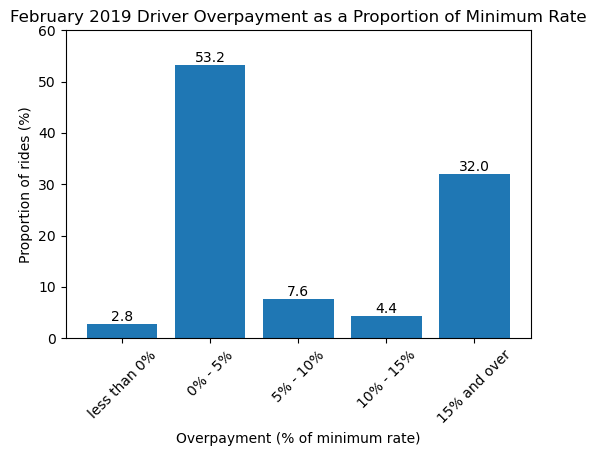

In [53]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(x = bin_labels, height = rides2019.groupby("perc_over_range")["perc_over_range"].count()*100/len(rides2019["perc_over_range"]))
ax.set_ylim(0, 60)
ax.set_xlabel('Overpayment (% of minimum rate)')
ax.xaxis.set_tick_params(rotation=45)
ax.set_ylabel('Proportion of rides (%)')
ax.bar_label(ax.containers[0], fmt = '%.1f', label_type='edge')
ax.margins(y=0.1)
ax.set_title('February 2019 Driver Overpayment as a Proportion of Minimum Rate')

#### !! Percentage of rides where the driver made less than the minimum required rate

In [ ]:
len(rides2019[rides2019.perc_over_min_rate < 0])/len(rides2019)

#### !! Percentage of rides where the driver made 1% or less over the minimum required rate

In [ ]:
len(rides2019[rides2019.perc_over_min_rate <= 0.01])/len(rides2019)

#### !! Percentage of rides where the driver made 10% or less over the minimum required rate

In [ ]:
len(rides2019[rides2019.perc_over_min_rate <= 0.10])/len(rides2019)

#### !! Percentage of rides where the driver made 20% or less over the minimum required rate

In [ ]:
len(rides2019[rides2019.perc_over_min_rate <= 0.20])/len(rides2019)

#### Percentage of rides where the driver made more than 5% of the minimum required rate

In [ ]:
len(rides2019[rides2019.perc_over_min_rate > 0.05])/len(rides2019)

#### Percentage of rides where the driver made more than 10% of the minimum required rate

In [ ]:
len(rides2019[rides2019.perc_over_min_rate > 0.10])/len(rides2019)

#### Percentage of rides where the driver made more than 20% of the minimum required rate

In [ ]:
len(rides2019[rides2019.perc_over_min_rate > 0.20])/len(rides2019)

#### Distribution of driver pay for rides where the driver made less than the minimum rate

In [ ]:
rides2019[rides2019.perc_over_min_rate < 0].driver_pay.describe()

#### Distribution of underpayment for rides where the driver made less than the minimum rate

In [ ]:
rides2019[rides2019.perc_over_min_rate < 0].over_min_rate.describe()

#### (NEW) Distribution of proportion underpaid for rides where the driver made less than the minimum rate

In [ ]:
rides2019[rides2019.perc_over_min_rate < 0].perc_over_min_rate.describe()

#### Total dollar amount underpaid

In [ ]:
(rides2019[rides2019.perc_over_min_rate < 0]["over_min_rate"] * -1).sum()

#### Percent of underpaid trips underpaid by 1% or more

In [ ]:
num_underpaid = len(rides2019[rides2019.perc_over_min_rate < 0])

len(rides2019[rides2019.perc_over_min_rate <= -0.01])/num_underpaid

#### Percent of underpaid trips underpaid by 2% or more

In [ ]:
len(rides2019[rides2019.perc_over_min_rate <= -0.02])/num_underpaid

#### Percent of underpaid trips underpaid by 5% or more

In [ ]:
len(rides2019[rides2019.perc_over_min_rate <= -0.05])/num_underpaid

#### Percent of underpaid trips underpaid by 10% or more

In [ ]:
len(rides2019[rides2019.perc_over_min_rate <= -0.10])/num_underpaid

#### Percent of underpaid trips underpaid by 25% or more

In [ ]:
len(rides2019[rides2019.perc_over_min_rate <= -0.25])/num_underpaid

#### Percent of underpaid trips underpaid by 50% or more

In [ ]:
len(rides2019[rides2019.perc_over_min_rate <= -0.50])/num_underpaid

#### Percent of underpaid trips underpaid by 0 - 5%

In [ ]:
len(rides2019[(rides2019.perc_over_min_rate < 0) & (rides2019.perc_over_min_rate >= -0.05)])/num_underpaid

#### Percent of underpaid trips underpaid by 5- 10%

In [ ]:
len(rides2019[(rides2019.perc_over_min_rate < -0.05) & (rides2019.perc_over_min_rate >= -0.1)])/num_underpaid

#### Percent of underpaid trips underpaid by 10 - 15%

In [ ]:
len(rides2019[(rides2019.perc_over_min_rate < -0.1) & (rides2019.perc_over_min_rate >= -.15)])/num_underpaid

#### Percent of underpaid trips underpaid by 15 - 20%

In [ ]:
len(rides2019[(rides2019.perc_over_min_rate < -0.15) & (rides2019.perc_over_min_rate >= -.2)])/num_underpaid

#### Percent of underpaid trips underpaid by 20% or more

In [ ]:
len(rides2019[(rides2019.perc_over_min_rate < -0.20)])/num_underpaid

In [46]:
underpaid = pd.DataFrame(data = rides2019[rides2019["perc_over_min_rate"] < 0], columns = ["perc_over_min_rate"]).reset_index(drop = True)

In [47]:
underpaid['perc_under'] = underpaid[underpaid["perc_over_min_rate"] < 0]["perc_over_min_rate"]*(-1)

In [48]:
bin_labels = ['0% - 5%','5% - 10%', '10% - 15%', '15% - 20%', '20% and over']
bins = [0, 0.05, 0.10, 0.15, 0.2, float('inf')]

underpaid['perc_under_range'] = pd.cut(underpaid["perc_under"], bins= bins, labels=bin_labels)

Text(0.5, 1.0, 'February 2019 Driver Underpayment as a Proportion of Minimum Rate')

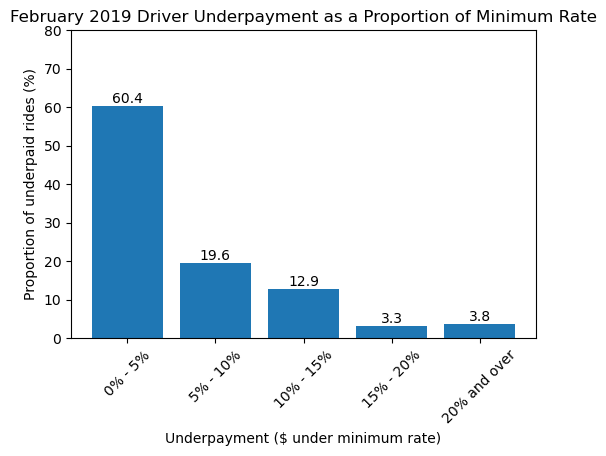

In [49]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(x = bin_labels, height = underpaid.groupby("perc_under_range")["perc_under_range"].count()*100/len(underpaid["perc_under_range"]))
ax.set_ylim(0, 80)
ax.set_xlabel('Underpayment ($ under minimum rate)')
ax.xaxis.set_tick_params(rotation=45)
ax.set_ylabel('Proportion of underpaid rides (%)')
ax.bar_label(ax.containers[0], fmt = '%.1f', label_type='edge')
ax.margins(y=0.1)
ax.set_title('February 2019 Driver Underpayment as a Proportion of Minimum Rate')

#### Percent of underpaid trips underpaid by \\$0.50 or more

In [ ]:
len(rides2019[(rides2019.over_min_rate <= -0.50)])/num_underpaid

#### Percent of underpaid trips underpaid by \\$1.00 or more

In [ ]:
len(rides2019[(rides2019.over_min_rate <= -1.00)])/num_underpaid

#### Percent of underpaid trips underpaid by \\$1.50 or more

In [ ]:
len(rides2019[(rides2019.over_min_rate <= -1.50)])/num_underpaid

#### Percent of underpaid trips underpaid by \\$2.00 or more

In [ ]:
len(rides2019[(rides2019.over_min_rate <= -2.00)])/num_underpaid

In [16]:
underpaid_dollar = pd.DataFrame(data = rides2019[rides2019["over_min_rate"] < 0], columns = ["over_min_rate"]).reset_index(drop = True)

In [17]:
underpaid_dollar['dollar_under'] = underpaid_dollar["over_min_rate"]*(-1)
underpaid_dollar

,over_min_rate,dollar_under
0,-0.17534,0.17534
1,-0.50446,0.50446
2,-2.07117,2.07117
3,-1.22036,1.22036
4,-2.66557,2.66557
...,...,...
390182,-3.81323,3.81323
390183,-0.01020,0.01020
390184,-0.03499,0.03499
390185,-0.47224,0.47224


In [35]:
bin_labels = ['\$0.00 to \$0.50','\$0.50 to \$1.00', '\$1.00 to \$1.50','\$1.50 to \$2.00','\$2.00 to \$2.50','\$2.50 to \$3.00', '\$3.00 to \$3.50', '\$3.50 or more']
bins = [0, 0.50, 1.00, 1.50, 2.00, 2.50, 3.00, 3.50, float('inf')]

underpaid_dollar['dollar_under_range'] = pd.cut(underpaid_dollar['dollar_under'], bins= bins, labels=bin_labels)

Text(0.5, 1.0, 'February 2019 Driver Underpayment in Dollars')

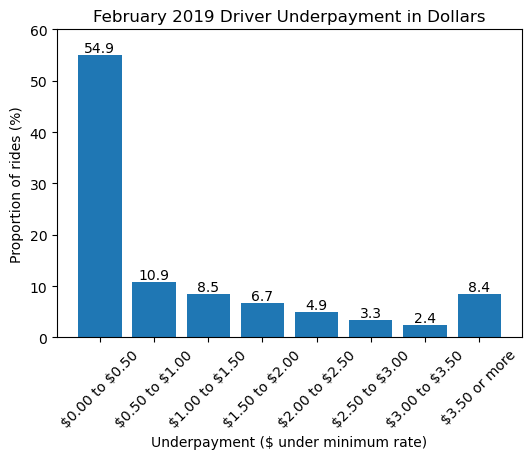

In [44]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(x = bin_labels, height = underpaid_dollar.groupby("dollar_under_range")["dollar_under_range"].count()*100/len(underpaid_dollar["dollar_under_range"]))
ax.set_ylim(0, 60)
ax.set_xlabel('Underpayment ($ under minimum rate)')
ax.xaxis.set_tick_params(rotation=45)
ax.set_ylabel('Proportion of rides (%)')
ax.bar_label(ax.containers[0], fmt = '%.1f', label_type='edge')
ax.margins(y=0.1)
ax.set_title('February 2019 Driver Underpayment in Dollars')

#### Distribution of minimum rate (in dollars) for rides where the driver made less than minimum rate

In [ ]:
rides2019[rides2019.perc_over_min_rate < 0].min_rate.describe()

#### Distribution of ride length (in miles) for rides where the driver made less than minimum rate

In [ ]:
rides2019[rides2019.perc_over_min_rate < 0].trip_miles.describe()

#### (NEW) Distribution of ride length (in minutes) for rides where the driver made less than minimum rate

In [ ]:
rides2019["trip_time_min"] = rides2019["trip_time"]/60
rides2019[rides2019.perc_over_min_rate < 0]["trip_time_min"].describe()

#### Distribution of driver pay for rides where the driver made over 20% of the minimum rate

In [ ]:
rides2019[rides2019.perc_over_min_rate > .2].driver_pay.describe()

#### Distribution of overage (in dollars) for rides where the driver made over 20% of the minimum rate

In [ ]:
rides2019[rides2019.perc_over_min_rate > .2]["over_min_rate"].describe()

#### Distribution of minimum rate (in dollars) for rides where the driver made over 20% of the minimum rate

In [ ]:
rides2019[rides2019.perc_over_min_rate > .2]["min_rate"].describe()

#### !! Percent of trips where overage is more than \$1

In [ ]:
len(rides2019[rides2019['over_min_rate'] > 1])/len(rides2019)

#### !! Percent of trips where overage was \$20 or more

In [ ]:
len(rides2019[rides2019['over_min_rate'] > 20])/len(rides2019)

#### !! Average overage of all trips in dollars

In [ ]:
rides2019['over_min_rate'].describe()

#### !! Average overage of trips that were 10% or less over in dollars

In [ ]:
rides2019[rides2019['perc_over_min_rate'] < .1]['over_min_rate'].describe()

#### !! Average overage of all trips which are over pay rules in dollars

In [ ]:
rides2019[rides2019['over_min_rate'] > 0]['over_min_rate'].describe()

#### Driver pay per minute/per mile

In [ ]:
rides2019['driver_pay_mile'] = rides2019.driver_pay/rides2019.trip_miles
rides2019['driver_pay_min'] = rides2019.driver_pay/(rides2019.trip_time/60)

In [ ]:
np.mean(rides2019['driver_pay_mile'])

In [ ]:
np.mean(rides['driver_pay_min'])

## Passenger Fare Analysis

In [ ]:
# Total passenger fare across all rides

rides2019['base_passenger_fare'].sum()    

In [ ]:
rides2019['passenger_fare_mile'] = rides2019.base_passenger_fare/rides2019.trip_miles
rides2019['passenger_fare_min'] = rides2019.base_passenger_fare/(rides2019.trip_time/60)

#### Distribution of passenger fare

In [ ]:
rides2019.base_passenger_fare.describe()

#### Average fare per minute cost 

In [ ]:
np.mean(rides2019['passenger_fare_min'])

#### Average fare per mile cost

In [ ]:
np.mean(rides2019['passenger_fare_mile'])

#### Regression of minutes and miles by passenger fare (In 2022, each additional mile per trip increases the fare by 2.03 dollars and each additional minute per trip increases the fare by 0.47 dollars)



In [ ]:
# convert trip time to minutes
rides2019['trip_time_min'] = rides2019.trip_time/60

In [ ]:
result = sm.ols(formula="base_passenger_fare ~ trip_miles + trip_time_min", data=rides2019).fit()
print(result.params)

## Drivers' earnings compared to passenger fare

In [ ]:
rides2019['perc_earnings_fare'] = rides2019["driver_pay"]/rides2019["base_passenger_fare"]

rides2019["perc_earnings_fare"].describe()

In [ ]:
rides2019[rides2019["perc_earnings_fare"] > 1]["driver_pay"].describe()

In [ ]:
rides2019[rides2019["perc_earnings_fare"] < 1]["driver_pay"].describe()

In [ ]:
len(rides2019[rides2019["perc_earnings_fare"] > 1])/len(rides2019["perc_earnings_fare"])

### Plot of proportion of passenger fare that the company takes

In [54]:
rides2019['perc_uber_takes'] = 1 - rides2019["driver_pay"]/rides2019["base_passenger_fare"]

In [55]:
bin_labels = ['less than -20%', '-20 - -10%', '-10 - 0%', '0% - 10%','10% - 20%', '20% - 30%', '30% - 40%', '40% and over']
bins = [float('-inf'), -.20, -.10, 0, 0.10, 0.20, 0.30, 0.40, float('inf')]

rides2019['perc_uber_takes_range'] = pd.cut(rides2019['perc_uber_takes'], bins= bins, labels=bin_labels)

Text(0.5, 1.0, 'February 2019, Proportion of Passenger Fare that the Company Takes')

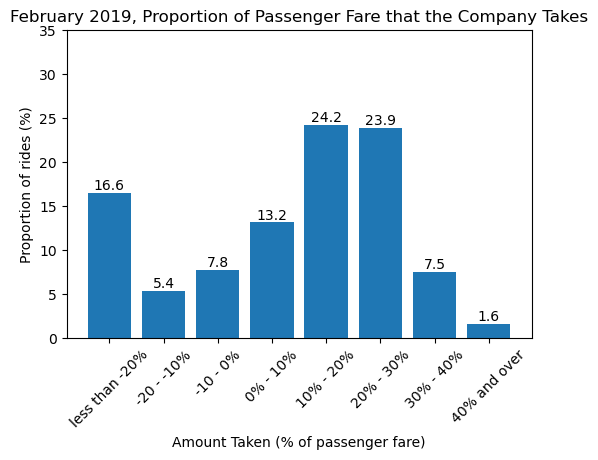

In [56]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(x = bin_labels, height = rides2019.groupby("perc_uber_takes_range")["perc_uber_takes_range"].count()*100/len(rides2019["perc_uber_takes_range"]))
ax.set_ylim(0, 35)
ax.set_xlabel('Amount Taken (% of passenger fare)')
ax.xaxis.set_tick_params(rotation=45)
ax.set_ylabel('Proportion of rides (%)')
ax.bar_label(ax.containers[0], fmt = '%.1f', label_type='edge')
ax.margins(y=0.1)
ax.set_title('February 2019, Proportion of Passenger Fare that the Company Takes')

## Losses on rides

#### Distribution of the percentage losses taken (among rides where a loss was taken)

In [ ]:
rides2019[rides2019['perc_uber_takes'] < 0]['perc_uber_takes'].describe()

#### Distribution of the percentage made over the minimum rate (among rides where a loss was taken)

In [ ]:
rides2019[rides2019['perc_uber_takes'] < 0]['perc_over_min_rate'].describe()

In [ ]:
rides2019[(rides2019['perc_uber_takes'] < 0) & (rides2019['perc_over_min_rate'] < 0)]['perc_over_min_rate'].describe()

#### Distribution of percentage underpaid (among underpaid rides where a loss was taken)

In [36]:
rides2019[(rides2019['perc_uber_takes'] < 0) & (rides2019['perc_over_min_rate'] < 0)]['perc_over_min_rate'].describe()

count   31896.00000
mean       -0.08119
std         0.14503
min        -0.95665
25%        -0.11114
50%        -0.00073
75%        -0.00018
max        -0.00000
Name: perc_over_min_rate, dtype: float64

#### Distribution of dollar amount underpaid (among underpaid rides where a loss was taken)

In [37]:
rides2019[(rides2019['perc_uber_takes'] < 0) & (rides2019['perc_over_min_rate'] < 0)]['over_min_rate'].describe()

count   31896.00000
mean       -2.15275
std         6.74964
min      -208.39431
25%        -1.87430
50%        -0.01140
75%        -0.00299
max        -0.00000
Name: over_min_rate, dtype: float64

#### Distribution of the dollar amount made over the minimum rate (among rides where a loss was taken)

In [ ]:
rides2019[rides2019['perc_uber_takes'] < 0]['over_min_rate'].describe()

#### Distribution of the percentage made over the minimum rate (among rides where a loss was not taken)

In [ ]:
rides2019[rides2019['perc_uber_takes'] >= 0]['perc_over_min_rate'].describe()

#### Distribution of the dollar amount made over the minimum rate (among rides where a loss was not taken)

In [ ]:
rides2019[rides2019['perc_uber_takes'] >= 0]['over_min_rate'].describe()

#### Percentage of rides that made under the minimum rate when a loss was taken

In [ ]:
len(rides2019[(rides2019['perc_uber_takes'] < 0) & (rides2019['perc_over_min_rate'] < 0)]['perc_over_min_rate'])/ len(rides2019[rides2019['perc_uber_takes'] < 0]['perc_over_min_rate'])

## Trip lengths

In [ ]:
rides2019["trip_time_min"].describe()

In [ ]:
rides2019["trip_miles"].describe()

# February 2019 (adjusted)

## Driver pay analysis

In [ ]:
# adjust 2019 data to 2022 dollar inflation rate

rides2019['driver_pay_adj'] = rides2019.driver_pay * 1.159 #inflation rate between 2019 and 2022

In [ ]:
# Total driver pay across all rides

rides2019['driver_pay_adj'].sum()    

In [ ]:
# Create dollar amount of min rate adjusted to inflation

rides2019['min_rate_adj'] = rides2019.min_rate * 1.159

In [ ]:
# Create variable for dollar amount of driver pay over min rate

rides2019['over_min_rate_adj'] = (rides2019.driver_pay_adj - rides2019.min_rate_adj)

In [ ]:
# Create variable for percentage of driver pay over min rate

rides2019['perc_over_min_rate_adj'] = (rides2019.over_min_rate_adj/(rides2019.min_rate_adj))

In [ ]:
# Create rate of passenger fare, by mile and minute

rides2019['passenger_fare_mile_adj'] = rides2019.base_passenger_fare * 1.159/rides2019.trip_miles
rides2019['passenger_fare_min_adj'] = rides2019.base_passenger_fare * 1.159/(rides2019.trip_time/60)

In [ ]:
# Determine percent of trips that leave city 
# Drop Shared rides, out of town rides, and VIA rides

rides2019 = rides2019.loc[rides2019['shared_match_flag'] == "N"]
rides2019 = rides2019.loc[rides2019['hvfhs_license_num'] != VIA]
rides2019 = rides2019.loc[rides2019['out_of_city'] == False]

In [ ]:
rides2019.driver_pay_adj.describe()

#### Distribution of percentage of driver earnings over the minimum required rate for the trip (In 2022 the bottom 25% of trips made less than 0.5% over the minimum rate, the top 25% of trips made at least 30% over the minimum rate, and the median percent made over the minimum rate was 7%)

In [ ]:
rides2019.perc_over_min_rate_adj.describe()

#### !! Percentage of rides where the driver made less than the minimum required rate

In [ ]:
len(rides2019[rides2019.perc_over_min_rate_adj < 0])/len(rides2019)

#### !! Percentage of rides where the driver made 1% or less over the minimum required rate

In [ ]:
len(rides2019[rides2019.perc_over_min_rate_adj <= 0.01])/len(rides2019)

#### !! Percentage of rides where the driver made 10% or less over the minimum required rate

In [ ]:
len(rides2019[rides2019.perc_over_min_rate_adj <= 0.10])/len(rides2019)

#### Percentage of rides where the driver made more than 5% of the minimum required rate

In [ ]:
len(rides2019[rides2019.perc_over_min_rate_adj > 0.05])/len(rides2019)

#### Percentage of rides where the driver made more than 10% of the minimum required rate

In [ ]:
len(rides2019[rides2019.perc_over_min_rate_adj > 0.10])/len(rides2019)

#### Percentage of rides where the driver made more than 20% of the minimum required rate

In [ ]:
len(rides2019[rides2019.perc_over_min_rate_adj > 0.20])/len(rides2019)

#### Distribution of driver pay for rides where the driver made less than the minimum rate

In [ ]:
rides2019[rides2019.perc_over_min_rate_adj < 0].driver_pay_adj.describe()

#### Distribution of underpayment for rides where the driver made less than the minimum rate

In [ ]:
rides2019[rides2019.perc_over_min_rate_adj < 0].over_min_rate_adj.describe()

#### (NEW) Distribution of proportion underpaid for rides where the driver made less than the minimum rate

In [ ]:
rides2019[rides2019.perc_over_min_rate_adj < 0]["perc_over_min_rate_adj"].describe()

In [ ]:
num_underpaid = len(rides2019[rides2019.perc_over_min_rate_adj < 0])

#### Percent of underpaid trips underpaid by 0 - 5%

In [ ]:
len(rides2019[(rides2019.perc_over_min_rate_adj < 0) & (rides2019.perc_over_min_rate_adj >= -0.05)])/num_underpaid

#### Percent of underpaid trips underpaid by 5- 10%

In [ ]:
len(rides2019[(rides2019.perc_over_min_rate_adj < -0.05) & (rides2019.perc_over_min_rate_adj >= -0.1)])/num_underpaid

#### Percent of underpaid trips underpaid by 10 - 15%

In [ ]:
len(rides2019[(rides2019.perc_over_min_rate_adj < -0.1) & (rides2019.perc_over_min_rate_adj >= -.15)])/num_underpaid

#### Percent of underpaid trips underpaid by 15 - 20%

In [ ]:
len(rides2019[(rides2019.perc_over_min_rate_adj < -0.15) & (rides2019.perc_over_min_rate_adj >= -.2)])/num_underpaid

#### Percent of underpaid trips underpaid by 20% or more

In [ ]:
len(rides2019[(rides2019.perc_over_min_rate_adj < -0.20)])/num_underpaid

In [ ]:
underpaid = pd.DataFrame(data = rides2019[rides2019["perc_over_min_rate"] < 0], columns = ["perc_over_min_rate"]).reset_index(drop = True)

In [ ]:
underpaid['perc_under'] = underpaid[underpaid["perc_over_min_rate"] < 0]["perc_over_min_rate"]*(-1)

In [ ]:
bin_labels = ['0% - 5%','5% - 10%', '10% - 15%', '15% - 20%', '20% and over']
bins = [0, 0.05, 0.10, 0.15, 0.2, float('inf')]

underpaid['perc_under_range'] = pd.cut(underpaid["perc_under"], bins= bins, labels=bin_labels)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(x = bin_labels, height = underpaid.groupby("perc_under_range")["perc_under_range"].count()*100/len(underpaid["perc_under_range"]))
ax.set_ylim(0, 80)
ax.set_xlabel('Underpayment (% of minimum rate)')
ax.xaxis.set_tick_params(rotation=45)
ax.set_ylabel('Proportion of underpaid rides (%)')
ax.bar_label(ax.containers[0], fmt = '%.1f', label_type='edge')
ax.margins(y=0.1)
ax.set_title('February 2019 Driver Underpayment as a Proportion of Minimum Rate')

#### Percent of underpaid trips underpaid by \\$0.50 or more

In [ ]:
len(rides2019[(rides2019.over_min_rate <= -0.50)])/num_underpaid

#### Percent of underpaid trips underpaid by \\$1.00 or more

In [ ]:
len(rides2019[(rides2019.over_min_rate <= -1.00)])/num_underpaid

#### Percent of underpaid trips underpaid by \\$1.50 or more

In [ ]:
len(rides2019[(rides2019.over_min_rate <= -1.50)])/num_underpaid

#### Percent of underpaid trips underpaid by \\$2.00 or more

In [ ]:
len(rides2019[(rides2019.over_min_rate <= -2.00)])/num_underpaid

In [ ]:
underpaid_dollar = pd.DataFrame(data = rides2019[rides2019["over_min_rate"] < 0], columns = ["over_min_rate"]).reset_index(drop = True)

In [ ]:
underpaid_dollar['dollar_under'] = underpaid_dollar["over_min_rate"]*(-1)
underpaid_dollar

In [ ]:
bin_labels = ['\$0.00 to \$0.50','\$0.50 to \$1.00', '\$1.00 to \$1.50','\$1.50 to \$2.00','\$2.00 to \$2.50','\$2.50 to \$3.00', '\$3.00 to \$3.50', '\$3.50 or more']
bins = [0, 0.50, 1.00, 1.50, 2.00, 2.50, 3.00, 3.50, float('inf')]

underpaid_dollar['dollar_under_range'] = pd.cut(underpaid_dollar['dollar_under'], bins= bins, labels=bin_labels)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(x = bin_labels, height = underpaid_dollar.groupby("dollar_under_range")["dollar_under_range"].count()*100/len(underpaid_dollar["dollar_under_range"]))
ax.set_ylim(0, 60)
ax.set_xlabel('Underpayment ($ under minimum rate)')
ax.xaxis.set_tick_params(rotation=45)
ax.set_ylabel('Proportion of rides (%)')
ax.bar_label(ax.containers[0], fmt = '%.1f', label_type='edge')
ax.margins(y=0.1)
ax.set_title('February 2019 Driver Underpayment in Dollars')

#### Distribution of minimum rate (in dollars) for rides where the driver made less than minimum rate

In [ ]:
rides2019[rides2019.perc_over_min_rate_adj < 0].min_rate_adj.describe()

#### Distribution of ride length for rides where the driver made less than minimum rate

In [ ]:
rides2019[rides2019.perc_over_min_rate_adj < 0].trip_miles.describe()

#### (NEW) Distribution of ride length (in minutes) for rides where the driver made less than minimum rate

In [ ]:
rides2019["trip_time_min"] = rides2019["trip_time"]/60
rides2019[rides2019.perc_over_min_rate < 0]["trip_time_min"].describe()

#### Distribution of driver pay for rides where the driver made over 20% of the minimum rate

In [ ]:
rides2019[rides2019.perc_over_min_rate_adj > .2].driver_pay_adj.describe()

#### Distribution of overage (in dollars) for rides where the driver made over 20% of the minimum rate

In [ ]:
rides2019[rides2019.perc_over_min_rate_adj > .2]["over_min_rate_adj"].describe()

#### Distribution of minimum rate (in dollars) for rides where the driver made over 20% of the minimum rate

In [ ]:
rides2019[rides2019.perc_over_min_rate > .2]["min_rate_adj"].describe()

#### Distribution of driver pay for rides where the driver made over 20% of the minimum rate (2022 dollars)

In [ ]:
rides2019[rides2019.perc_over_min_rate_adj > .2].driver_pay_adj.describe()

#### !! Percent of trips where overage is more than \$1

In [ ]:
len(rides2019[rides2019['over_min_rate_adj'] > 1])/len(rides2019)

#### !! Percent of trips where overage was \$20 or more

In [ ]:
len(rides2019[rides2019['over_min_rate_adj'] > 20])/len(rides2019)

#### !! Average overage of all trips in dollars

In [ ]:
rides2019['over_min_rate_adj'].describe()

#### !! Average overage of trips that were 10% or less over in dollars

In [ ]:
rides2019[rides2019['perc_over_min_rate_adj'] < .1]['over_min_rate_adj'].describe()

#### !! Average overage of all trips which are over pay rules in dollars

In [ ]:
rides2019[rides2019['over_min_rate_adj'] > 0]['over_min_rate_adj'].describe()

#### Driver Pay Min/mile

In [ ]:
rides2019['driver_pay_mile_adj'] = rides2019.driver_pay_adj/rides2019.trip_miles
rides2019['driver_pay_min_adj'] = rides2019.driver_pay_adj/(rides2019.trip_time/60)

In [ ]:
np.mean(rides2019['driver_pay_mile_adj'])

In [ ]:
np.mean(rides2019['driver_pay_min_adj'])

## Passenger Fare Analysis

In [ ]:
# Convert 2019 base passenger fare to 2022 dollars

rides2019['passenger_fare_adj'] = rides2019.base_passenger_fare * 1.159 #inflation rate between 2019 and 2022
rides2019['passenger_fare_mile_adj'] = rides2019.base_passenger_fare*1.159/rides2019.trip_miles
rides2019['passenger_fare_min_adj'] = rides2019.base_passenger_fare*1.159/(rides2019.trip_time/60)

In [10]:
# Total passenger fare across all rides

rides2019['passenger_fare_adj'].sum()  

NameError: name 'rides2019' is not defined

#### Distribution of passenger fare

In [ ]:
rides2019.passenger_fare_adj.describe()

#### Average fare per minute cost 

In [ ]:
np.mean(rides2019['passenger_fare_min_adj'])

#### Average fare per mile cost (2022 Dollars)

In [ ]:
np.mean(rides2019['passenger_fare_mile_adj'])

#### Regression of minutes and miles by passenger fare (In 2022, each additional mile per trip increases the fare by 2.03 dollars and each additional minute per trip increases the fare by 0.47 dollars)



In [ ]:
# convert trip time to minutes
rides2019['trip_time_min'] = rides2019.trip_time/60

In [ ]:
result = sm.ols(formula="passenger_fare_adj ~ trip_miles + trip_time_min", data=rides2019).fit()
print(result.params)

## Drivers' earnings compared to passenger fare

In [ ]:
rides2019['perc_earnings_fare_adj'] = rides2019["driver_pay_adj"]/rides2019["passenger_fare_adj"]

rides2019["perc_earnings_fare_adj"].describe()

In [ ]:
rides2019[rides2019["perc_earnings_fare_adj"] > 1]["perc_earnings_fare_adj"].describe()

In [ ]:
rides2019[rides2019["perc_earnings_fare_adj"] < 1]["perc_earnings_fare_adj"].describe()

## Trip lengths

In [ ]:
rides2019["trip_time_min"].describe()

In [ ]:
rides2019["trip_miles"].describe()

# October 2019 (not adjusted)

In [3]:
# Import Cleaned Data

oct2019 = pq.read_table("../Aya_NYTWA/Data/october_2019_cleaned.parquet", memory_map=True).to_pandas()

In [4]:
# Create minimum rates 2019 based on WAV and Out of City Conditions

conditions2019 = [
    (oct2019['wav_match_flag'] == 'N') & (oct2019['out_of_city'] == False),
    (oct2019['wav_match_flag'] == 'Y') & (oct2019['out_of_city'] == False),
    (oct2019['wav_match_flag'] == 'N') & (oct2019['out_of_city'] == True),
    (oct2019['wav_match_flag'] == 'Y') & (oct2019['out_of_city'] == True)]

choices2019 = [oct2019.trip_miles*NON_WAV_PER_MILE_19 + (oct2019.trip_time/60)*NON_WAV_PER_MIN_19,
              oct2019.trip_miles*WAV_PER_MILE_19 + (oct2019.trip_time/60)*WAV_PER_MIN_19,
              oct2019.trip_miles*OUT_CITY_NON_WAV_PER_MILE_19 + (oct2019.trip_time/60)*OUT_CITY_PER_MIN_19,
              oct2019.trip_miles*OUT_CITY_WAV_PER_MILE_19 + (oct2019.trip_time/60)*OUT_CITY_PER_MIN_19]

oct2019['min_rate'] = np.select(conditions2019, choices2019, default=oct2019.trip_miles*NON_WAV_PER_MILE_19 + (oct2019.trip_time/60)*NON_WAV_PER_MIN_19)

# Determine percent of trips that leave city 
# Drop Shared rides, out of town rides, and VIA rides

oct2019 = oct2019.loc[oct2019['shared_match_flag'] == "N"]
oct2019 = oct2019.loc[oct2019['hvfhs_license_num'] != VIA]
oct2019 = oct2019.loc[oct2019['out_of_city'] == False]

## Driver pay analysis

#### Distribution of driver pay

In [8]:
oct2019['driver_pay'].sum()

251517057.91999948

In [9]:
oct2019['driver_pay'].describe()

count   16695576.00000
mean          15.06489
std           11.53104
min            0.02000
25%            7.01000
50%           11.42000
75%           18.88000
max          664.12000
Name: driver_pay, dtype: float64

## Passenger Fare Analysis

In [12]:
# Total passenger fare across all rides

oct2019['base_passenger_fare'].sum()  

299588560.20999986

#### Distribution of passenger fare

In [13]:
oct2019.base_passenger_fare.describe()

count   16695576.00000
mean          17.94419
std           14.45963
min            0.02000
25%            8.50000
50%           13.44000
75%           22.37000
max         2419.64000
Name: base_passenger_fare, dtype: float64

## Drivers' earnings compared to passenger fare

In [20]:
oct2019['perc_earnings_fare_adj'] = oct2019["driver_pay_adj"]/oct2019["passenger_fare_adj"]

oct2019["perc_earnings_fare_adj"].describe()

count   16695576.00000
mean           0.92704
std            1.66281
min            0.00015
25%            0.71987
50%            0.79767
75%            0.96110
max         1755.50000
Name: perc_earnings_fare_adj, dtype: float64

In [21]:
oct2019[oct2019["perc_earnings_fare_adj"] > 1]["perc_earnings_fare_adj"].describe()

count   3661514.00000
mean          1.50667
std           3.48338
min           1.00010
25%           1.10537
50%           1.30114
75%           1.54848
max        1755.50000
Name: perc_earnings_fare_adj, dtype: float64

In [22]:
oct2019[oct2019["perc_earnings_fare_adj"] < 1]["perc_earnings_fare_adj"].describe()

count   13021017.00000
mean           0.76397
std            0.10997
min            0.00015
25%            0.69505
50%            0.75630
75%            0.83700
max            0.99989
Name: perc_earnings_fare_adj, dtype: float64

## Losses on rides

In [25]:
oct2019['perc_uber_takes'] = 1 - oct2019["driver_pay_adj"]/oct2019["passenger_fare_adj"]

#### Distribution of the percentage losses taken (among rides where a loss was taken)

In [26]:
oct2019[oct2019['perc_uber_takes'] < 0]['perc_uber_takes'].describe()

count   3661514.00000
mean         -0.50667
std           3.48338
min       -1754.50000
25%          -0.54848
50%          -0.30114
75%          -0.10537
max          -0.00010
Name: perc_uber_takes, dtype: float64

#### Distribution of the percentage made over the minimum rate (among rides where a loss was taken)

In [27]:
oct2019[oct2019['perc_uber_takes'] < 0]['perc_over_min_rate'].describe()

count   3661514.00000
mean          0.22734
std           0.98086
min          -0.97029
25%           0.00157
50%           0.00241
75%           0.18736
max         460.65084
Name: perc_over_min_rate, dtype: float64

In [28]:
oct2019[(oct2019['perc_uber_takes'] < 0) & (oct2019['perc_over_min_rate'] < 0)]['perc_over_min_rate'].describe()

count   16738.00000
mean       -0.09058
std         0.18401
min        -0.97029
25%        -0.06579
50%        -0.00025
75%        -0.00009
max        -0.00000
Name: perc_over_min_rate, dtype: float64

#### Distribution of percentage underpaid (among underpaid rides where a loss was taken)

In [29]:
oct2019[(oct2019['perc_uber_takes'] < 0) & (oct2019['perc_over_min_rate'] < 0)]['perc_over_min_rate'].describe()

count   16738.00000
mean       -0.09058
std         0.18401
min        -0.97029
25%        -0.06579
50%        -0.00025
75%        -0.00009
max        -0.00000
Name: perc_over_min_rate, dtype: float64

#### Distribution of dollar amount underpaid (among underpaid rides where a loss was taken)

In [30]:
oct2019[(oct2019['perc_uber_takes'] < 0) & (oct2019['perc_over_min_rate'] < 0)]['over_min_rate'].describe()

count   16738.00000
mean       -2.36526
std         6.76621
min      -181.25215
25%        -0.89920
50%        -0.00189
75%        -0.00071
max        -0.00000
Name: over_min_rate, dtype: float64

#### Distribution of the dollar amount made over the minimum rate (among rides where a loss was taken)

In [31]:
oct2019[oct2019['perc_uber_takes'] < 0]['over_min_rate'].describe()

count   3661514.00000
mean          1.42229
std           3.26901
min        -181.25215
25%           0.01750
50%           0.03951
75%           1.32941
max         284.90748
Name: over_min_rate, dtype: float64

#### Distribution of the percentage made over the minimum rate (among rides where a loss was not taken)

In [32]:
oct2019[oct2019['perc_uber_takes'] >= 0]['perc_over_min_rate'].describe()

count   13034062.00000
mean           0.16233
std            0.95294
min           -0.99928
25%            0.00169
50%            0.00247
75%            0.09096
max          405.86633
Name: perc_over_min_rate, dtype: float64

#### Distribution of the dollar amount made over the minimum rate (among rides where a loss was not taken)

In [33]:
oct2019[oct2019['perc_uber_takes'] >= 0]['over_min_rate'].describe()

count   13034062.00000
mean           1.20735
std            3.69062
min         -173.02507
25%            0.01726
50%            0.04031
75%            0.62311
max          377.18488
Name: over_min_rate, dtype: float64

#### Percentage of rides that made under the minimum rate when a loss was taken

In [34]:
len(oct2019[(oct2019['perc_uber_takes'] < 0) & (oct2019['perc_over_min_rate'] < 0)]['perc_over_min_rate'])/ len(oct2019[oct2019['perc_uber_takes'] < 0]['perc_over_min_rate'])

0.004571333060586413

## Trip lengths

In [10]:
oct2019["trip_time_min"].describe()

KeyError: 'trip_time_min'

In [ ]:
oct2019["trip_miles"].describe()

# October 2019 (adjusted)

## Driver pay analysis

#### Distribution of driver pay

In [7]:
oct2019['driver_pay_adj'].sum()

291508270.12928015

In [5]:
# Total driver pay across all rides

oct2019['driver_pay_adj'] = oct2019.driver_pay * 1.159 #inflation rate between 2019 and 2022

In [6]:
oct2019['driver_pay_adj'].describe()

count   16695576.00000
mean          17.46021
std           13.36448
min            0.02318
25%            8.12459
50%           13.23578
75%           21.88192
max          769.71508
Name: driver_pay_adj, dtype: float64

## Passenger Fare Analysis

In [15]:
# Convert 2019 base passenger fare to 2022 dollars

oct2019['passenger_fare_adj'] = oct2019.base_passenger_fare * 1.159 #inflation rate between 2019 and 2022
oct2019['passenger_fare_mile_adj'] = oct2019.base_passenger_fare*1.159/oct2019.trip_miles
oct2019['passenger_fare_min_adj'] = oct2019.base_passenger_fare*1.159/(oct2019.trip_time/60)

In [18]:
# Total passenger fare across all rides

oct2019['passenger_fare_adj'].sum()  

347223141.2833907

#### Distribution of passenger fare

In [19]:
oct2019.passenger_fare_adj.describe()

count   16695576.00000
mean          20.79731
std           16.75871
min            0.02318
25%            9.85150
50%           15.57696
75%           25.92683
max         2804.36276
Name: passenger_fare_adj, dtype: float64

## Drivers' earnings compared to passenger fare

In [16]:
oct2019['perc_earnings_fare_adj'] = oct2019["driver_pay_adj"]/oct2019["passenger_fare_adj"]

oct2019["perc_earnings_fare_adj"].describe()

count   16695576.00000
mean           0.92704
std            1.66281
min            0.00015
25%            0.71987
50%            0.79767
75%            0.96110
max         1755.50000
Name: perc_earnings_fare_adj, dtype: float64

In [20]:
len(oct2019[oct2019["perc_earnings_fare_adj"] > 1])/len(oct2019["perc_earnings_fare_adj"])

0.21931043289551674

In [17]:
oct2019[oct2019["perc_earnings_fare_adj"] > 1]["perc_earnings_fare_adj"].describe()

count   3661514.00000
mean          1.50667
std           3.48338
min           1.00010
25%           1.10537
50%           1.30114
75%           1.54848
max        1755.50000
Name: perc_earnings_fare_adj, dtype: float64

In [22]:
oct2019[oct2019["perc_earnings_fare_adj"] < 1]["perc_earnings_fare_adj"].describe()

count   13021017.00000
mean           0.76397
std            0.10997
min            0.00015
25%            0.69505
50%            0.75630
75%            0.83700
max            0.99989
Name: perc_earnings_fare_adj, dtype: float64

## Losses on rides

In [25]:
oct2019['perc_uber_takes'] = 1 - oct2019["driver_pay_adj"]/oct2019["passenger_fare_adj"]

#### Distribution of the percentage losses taken (among rides where a loss was taken)

In [26]:
oct2019[oct2019['perc_uber_takes'] < 0]['perc_uber_takes'].describe()

count   3661514.00000
mean         -0.50667
std           3.48338
min       -1754.50000
25%          -0.54848
50%          -0.30114
75%          -0.10537
max          -0.00010
Name: perc_uber_takes, dtype: float64

#### Distribution of the percentage made over the minimum rate (among rides where a loss was taken)

In [27]:
oct2019[oct2019['perc_uber_takes'] < 0]['perc_over_min_rate'].describe()

count   3661514.00000
mean          0.22734
std           0.98086
min          -0.97029
25%           0.00157
50%           0.00241
75%           0.18736
max         460.65084
Name: perc_over_min_rate, dtype: float64

In [28]:
oct2019[(oct2019['perc_uber_takes'] < 0) & (oct2019['perc_over_min_rate'] < 0)]['perc_over_min_rate'].describe()

count   16738.00000
mean       -0.09058
std         0.18401
min        -0.97029
25%        -0.06579
50%        -0.00025
75%        -0.00009
max        -0.00000
Name: perc_over_min_rate, dtype: float64

#### Distribution of percentage underpaid (among underpaid rides where a loss was taken)

In [29]:
oct2019[(oct2019['perc_uber_takes'] < 0) & (oct2019['perc_over_min_rate'] < 0)]['perc_over_min_rate'].describe()

count   16738.00000
mean       -0.09058
std         0.18401
min        -0.97029
25%        -0.06579
50%        -0.00025
75%        -0.00009
max        -0.00000
Name: perc_over_min_rate, dtype: float64

#### Distribution of dollar amount underpaid (among underpaid rides where a loss was taken)

In [30]:
oct2019[(oct2019['perc_uber_takes'] < 0) & (oct2019['perc_over_min_rate'] < 0)]['over_min_rate'].describe()

count   16738.00000
mean       -2.36526
std         6.76621
min      -181.25215
25%        -0.89920
50%        -0.00189
75%        -0.00071
max        -0.00000
Name: over_min_rate, dtype: float64

#### Distribution of the dollar amount made over the minimum rate (among rides where a loss was taken)

In [31]:
oct2019[oct2019['perc_uber_takes'] < 0]['over_min_rate'].describe()

count   3661514.00000
mean          1.42229
std           3.26901
min        -181.25215
25%           0.01750
50%           0.03951
75%           1.32941
max         284.90748
Name: over_min_rate, dtype: float64

#### Distribution of the percentage made over the minimum rate (among rides where a loss was not taken)

In [32]:
oct2019[oct2019['perc_uber_takes'] >= 0]['perc_over_min_rate'].describe()

count   13034062.00000
mean           0.16233
std            0.95294
min           -0.99928
25%            0.00169
50%            0.00247
75%            0.09096
max          405.86633
Name: perc_over_min_rate, dtype: float64

#### Distribution of the dollar amount made over the minimum rate (among rides where a loss was not taken)

In [33]:
oct2019[oct2019['perc_uber_takes'] >= 0]['over_min_rate'].describe()

count   13034062.00000
mean           1.20735
std            3.69062
min         -173.02507
25%            0.01726
50%            0.04031
75%            0.62311
max          377.18488
Name: over_min_rate, dtype: float64

#### Percentage of rides that made under the minimum rate when a loss was taken

In [34]:
len(oct2019[(oct2019['perc_uber_takes'] < 0) & (oct2019['perc_over_min_rate'] < 0)]['perc_over_min_rate'])/ len(oct2019[oct2019['perc_uber_takes'] < 0]['perc_over_min_rate'])

0.004571333060586413

## Trip lengths

In [10]:
oct2019["trip_time_min"].describe()

KeyError: 'trip_time_min'

In [ ]:
oct2019["trip_miles"].describe()

# April 2022

In [3]:
rides2022 = pq.read_table("../Aya_NYTWA/Data/april_2022_cleaned.parquet", memory_map=True).to_pandas()

In [4]:
# Create minimum rates 2022 based on WAV and Out of City Conditions

conditions2022 = [
    (rides2022['wav_match_flag'] == 'N') & (rides2022['out_of_city'] == False),
    (rides2022['wav_match_flag'] == 'Y') & (rides2022['out_of_city'] == False),
    (rides2022['wav_match_flag'] == 'N') & (rides2022['out_of_city'] == True),
    (rides2022['wav_match_flag'] == 'Y') & (rides2022['out_of_city'] == True)]

choices2022 = [rides2022.trip_miles*NON_WAV_PER_MILE_22 + (rides2022.trip_time/60)*NON_WAV_PER_MIN_22,
              rides2022.trip_miles*WAV_PER_MILE_22 + (rides2022.trip_time/60)*WAV_PER_MIN_22,
              rides2022.trip_miles*OUT_CITY_NON_WAV_PER_MILE_22 + (rides2022.trip_time/60)*OUT_CITY_PER_MIN_22,
              rides2022.trip_miles*OUT_CITY_WAV_PER_MILE_22 + (rides2022.trip_time/60)*OUT_CITY_PER_MIN_22]

rides2022['min_rate'] = np.select(conditions2022, choices2022, default=rides2022.trip_miles*NON_WAV_PER_MILE_22 + (rides2022.trip_time/60)*NON_WAV_PER_MIN_22)


In [5]:
# Create variable for dollar amount of driver pay over min rate

rides2022['over_min_rate'] = (rides2022.driver_pay - rides2022.min_rate)

In [6]:
# Create variable for percentage of driver pay over min rate

rides2022['perc_over_min_rate'] = (rides2022.over_min_rate/rides2022.min_rate)

In [7]:
# Create rate of passenger fare, by mile and minute


rides2022['passenger_fare_mile'] = rides2022.base_passenger_fare/rides2022.trip_miles
rides2022['passenger_fare_min'] = rides2022.base_passenger_fare/(rides2022.trip_time/60)

In [8]:
# Determine percent of trips that leave city 
# Drop Shared rides, out of town rides, and VIA rides

rides2022 = rides2022.loc[rides2022['hvfhs_license_num'] != VIA]

rides2022 = rides2022.loc[rides2022['out_of_city'] == False]

## Driver Pay Analysis


In [ ]:
# Total driver pay across all rides

rides2022['driver_pay'].sum()    

#### Distribution of driver pay (in 2022 dollars)

In [ ]:
rides2022.driver_pay.describe()

In [ ]:
rides.min_rate.describe()

#### Distribution of percentage of driver earnings over the minimum required rate for the trip (In 2022 the bottom 25% of trips made less than 0.5% over the minimum rate, the top 25% of trips made at least 30% over the minimum rate, and the median percent made over the minimum rate was 7%)

In [ ]:
rides2022.perc_over_min_rate.describe()

#### !! Percentage of rides where the driver made less than the minimum required rate

In [ ]:
bin_labels = ['less than 0%', '0% - 5%','5% - 10%', '10% - 15%', '15% and over']
bins = [float('-inf'), 0, 0.05, 0.10, 0.15, float('inf')]

rides2022['perc_over_range'] = pd.cut(rides2022['perc_over_min_rate'], bins= bins, labels=bin_labels)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(x = bin_labels, height = rides2022.groupby("perc_over_range")["perc_over_range"].count()*100/len(rides2022["perc_over_range"]))
ax.set_ylim(0, 60)
ax.set_xlabel('Overpayment (% of minimum rate)')
ax.xaxis.set_tick_params(rotation=45)
ax.set_ylabel('Proportion of rides (%)')
ax.bar_label(ax.containers[0], fmt = '%.1f', label_type='edge')
ax.margins(y=0.1)
ax.set_title('April 2022 Driver Overpayment as a Proportion of Minimum Rate')

In [ ]:
len(rides2022[rides2022.perc_over_min_rate < 0])/len(rides2022)

#### !! Percentage of rides where the driver made 1% or less over the minimum required rate

In [ ]:
len(rides2022[rides2022.perc_over_min_rate <= 0.01])/len(rides2022)

#### !! Percentage of rides where the driver made 10% or less over the minimum required rate

In [ ]:
len(rides2022[rides2022.perc_over_min_rate <= 0.10])/len(rides2022)

#### Percentage of rides where the driver made more than 5% of the minimum required rate

In [ ]:
len(rides2022[rides2022.perc_over_min_rate > 0.05])/len(rides2022)

#### Percentage of rides where the driver made more than 10% of the minimum required rate

In [ ]:
len(rides2022[rides2022.perc_over_min_rate > 0.10])/len(rides2022)

#### Percentage of rides where the driver made more than 20% of the minimum required rate

In [ ]:
len(rides2022[rides2022.perc_over_min_rate > 0.20])/len(rides2022)

#### Distribution of driver pay for rides where the driver made less than the minimum rate

In [ ]:
rides2022[rides2022.perc_over_min_rate < 0].driver_pay.describe()

#### Distribution of underpayment for rides where the driver made less than the minimum rate

In [ ]:
rides2022[rides2022.perc_over_min_rate < 0].over_min_rate.describe()

#### (NEW) Distribution of proportion underpaid for rides where the driver made less than the minimum rate

In [ ]:
rides2022[rides2022.perc_over_min_rate < 0].perc_over_min_rate.describe()

#### Distribution of minimum rate (in dollars) for rides where the driver made less than minimum rate

In [ ]:
rides2022[rides2022.perc_over_min_rate < 0].min_rate.describe()

#### Distribution of ride length for rides where the driver made less than minimum rate

In [ ]:
rides2022[rides2022.perc_over_min_rate < 0].trip_miles.describe()

#### (NEW) Distribution of ride length (in minutes) for rides where the driver made less than minimum rate

In [ ]:
rides2022["trip_time_min"] = rides2022["trip_time"]/60
rides2022[rides2022.perc_over_min_rate < 0]["trip_time_min"].describe()

In [ ]:
num_underpaid = len(rides2022[rides2022.perc_over_min_rate < 0])

len(rides2022[rides2022.perc_over_min_rate <= -0.01])/num_underpaid

#### Percent of underpaid trips underpaid by 2% or more

In [ ]:
len(rides2022[rides2022.perc_over_min_rate <= -0.02])/num_underpaid

#### Percent of underpaid trips underpaid by 5% or more

In [ ]:
len(rides2022[rides2022.perc_over_min_rate <= -0.05])/num_underpaid

#### Percent of underpaid trips underpaid by 10% or more

In [ ]:
len(rides2022[rides2022.perc_over_min_rate <= -0.10])/num_underpaid

#### Percent of underpaid trips underpaid by 25% or more

In [ ]:
len(rides2022[rides2022.perc_over_min_rate <= -0.25])/num_underpaid

#### Percent of underpaid trips underpaid by 50% or more

In [ ]:
len(rides2022[rides2022.perc_over_min_rate <= -0.50])/num_underpaid

#### Percent of underpaid trips underpaid by 0 - 5%

In [ ]:
len(rides2022[(rides2022.perc_over_min_rate < 0) & (rides2022.perc_over_min_rate >= -0.05)])/num_underpaid

#### Percent of underpaid trips underpaid by 5- 10%

In [ ]:
len(rides2022[(rides2022.perc_over_min_rate < -0.05) & (rides2022.perc_over_min_rate >= -0.1)])/num_underpaid

#### Percent of underpaid trips underpaid by 10 - 15%

In [ ]:
len(rides2022[(rides2022.perc_over_min_rate < -0.1) & (rides2022.perc_over_min_rate >= -.15)])/num_underpaid

#### Percent of underpaid trips underpaid by 15 - 20%

In [ ]:
len(rides2022[(rides2022.perc_over_min_rate < -0.15) & (rides2022.perc_over_min_rate >= -.2)])/num_underpaid

#### Percent of underpaid trips underpaid by 20% or more

In [ ]:
len(rides2022[(rides2022.perc_over_min_rate < -0.20)])/num_underpaid

#### Percent of underpaid trips underpaid by 0 - 0.5%

In [ ]:
len(rides2022[(rides2022.perc_over_min_rate < 0) & (rides2022.perc_over_min_rate >= -0.005)])/num_underpaid

In [ ]:
underpaid = pd.DataFrame(data = rides2022[rides2022["perc_over_min_rate"] < 0], columns = ["perc_over_min_rate"]).reset_index(drop = True)

In [ ]:
underpaid['perc_under'] = underpaid[underpaid["perc_over_min_rate"] < 0]["perc_over_min_rate"]*(-1)

In [ ]:
bin_labels = ['0% - 5%','5% - 10%', '10% - 15%', '15% - 20%', '20% and over']
bins = [0, 0.05, 0.10, 0.15, 0.2, float('inf')]

underpaid['perc_under_range'] = pd.cut(underpaid["perc_under"], bins= bins, labels=bin_labels)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(x = bin_labels, height = underpaid.groupby("perc_under_range")["perc_under_range"].count()*100/len(underpaid["perc_under_range"]))
ax.set_ylim(0, 100)
ax.set_xlabel('Underpayment (% of minimum rate)')
ax.xaxis.set_tick_params(rotation=45)
ax.set_ylabel('Proportion of underpaid rides (%)')
ax.bar_label(ax.containers[0], fmt = '%.1f', label_type='edge')
ax.margins(y=0.1)
ax.set_title('April 2022 Driver Underpayment as a Proportion of Minimum Rate')

#### Percent of underpaid trips underpaid by \\$0.50 or more

In [ ]:
len(rides2022[(rides2022.over_min_rate <= -0.50)])/num_underpaid

#### Percent of underpaid trips underpaid by \\$1.00 or more

In [ ]:
len(rides2022[(rides2022.over_min_rate <= -1.00)])/num_underpaid

#### Percent of underpaid trips underpaid by \\$1.50 or more

In [ ]:
len(rides2022[(rides2022.over_min_rate <= -1.50)])/num_underpaid

#### Percent of underpaid trips underpaid by \\$2.00 or more

In [ ]:
len(rides2022[(rides2022.over_min_rate <= -2.00)])/num_underpaid

In [ ]:
underpaid_dollar = pd.DataFrame(data = rides2022[rides2022["over_min_rate"] < 0], columns = ["over_min_rate"]).reset_index(drop = True)

In [ ]:
underpaid_dollar['dollar_under'] = underpaid_dollar["over_min_rate"]*(-1)
underpaid_dollar

In [ ]:
bin_labels = ['\$0.00 to \$0.50','\$0.50 to \$1.00', '\$1.00 to \$1.50','\$1.50 to \$2.00','\$2.00 to \$2.50','\$2.50 to \$3.00', '\$3.00 to \$3.50', '\$3.50 or more']
bins = [0, 0.50, 1.00, 1.50, 2.00, 2.50, 3.00, 3.50, float('inf')]

underpaid_dollar['dollar_under_range'] = pd.cut(underpaid_dollar['dollar_under'], bins= bins, labels=bin_labels)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(x = bin_labels, height = underpaid_dollar.groupby("dollar_under_range")["dollar_under_range"].count()*100/len(underpaid_dollar["dollar_under_range"]))
ax.set_ylim(0, 100)
ax.set_xlabel('Underpayment ($ under minimum rate)')
ax.xaxis.set_tick_params(rotation=45)
ax.set_ylabel('Proportion of rides (%)')
ax.bar_label(ax.containers[0], fmt = '%.1f', label_type='edge')
ax.margins(y=0.1)
ax.set_title('April 2022 Driver Underpayment in Dollars')

#### Distribution of driver pay for rides where the driver made over 20% of the minimum rate

In [ ]:
rides2022[rides2022.perc_over_min_rate > .2].driver_pay.describe()

#### Distribution of overage (in dollars) for rides where the driver made over 20% of the minimum rate

In [ ]:
rides2022[rides2022.perc_over_min_rate > .2]["over_min_rate"].describe()

#### Distribution of minimum rate (in dollars) for rides where the driver made over 20% of the minimum rate

In [ ]:
rides2022[rides2022.perc_over_min_rate > .2]["min_rate"].describe()

#### Distribution of driver pay for rides where the driver made over 20% of the minimum rate (2022 dollars)

In [ ]:
rides2022[rides2022.perc_over_min_rate > .2].driver_pay.describe()

#### !! Percent of trips where overage is more than \$1

In [ ]:
len(rides2022[rides2022['over_min_rate'] > 1])/len(rides2022)

#### !! Percent of trips where overage was \$20 or more

In [ ]:
len(rides2022[rides2022['over_min_rate'] > 20])/len(rides2022)

#### !! Average overage of all trips in dollars

In [ ]:
rides2022['over_min_rate'].describe()

#### !! Average overage of trips that were 10% or less over in dollars

In [ ]:
rides2022[rides2022['perc_over_min_rate'] < .1]['over_min_rate'].describe()

#### !! Average overage of all trips which are over pay rules in dollars

In [ ]:
rides2022[rides2022['over_min_rate'] > 0]['over_min_rate'].describe()

#### Driver Pay min/mile

In [ ]:
rides2022['driver_pay_mile'] = rides2022.driver_pay/rides2022.trip_miles
rides2022['driver_pay_min'] = rides2022.driver_pay/(rides2022.trip_time/60)

In [ ]:
np.mean(rides2022['driver_pay_mile'])

In [ ]:
np.mean(rides2022['driver_pay_min'])

## Passenger Fare Analysis

In [ ]:
# Total passenger fare across all rides

rides2022['base_passenger_fare'].sum()  

#### Distribution of passenger fare (2022 Dollars)

In [ ]:
rides2022.base_passenger_fare.describe()

#### Average fare per minute cost (2022 Dollars)

In [ ]:
np.mean(rides2022['passenger_fare_min'])

#### Average fare per mile cost (2022 Dollars)

In [ ]:
np.mean(rides2022['passenger_fare_mile'])

#### Regression of minutes and miles by passenger fare (In 2022, each additional mile per trip increases the fare by 2.03 dollars and each additional minute per trip increases the fare by 0.47 dollars)



In [ ]:
# convert trip time to minutes
rides2022['trip_time_min'] = rides2022.trip_time/60

In [ ]:
result = sm.ols(formula="base_passenger_fare ~ trip_miles + trip_time_min", data=rides2022).fit()
print(result.params)

## Drivers' earnings compared to passenger fare

In [10]:
rides2022['perc_earnings_fare'] = rides2022["driver_pay"]/rides2022["base_passenger_fare"]

rides2022["perc_earnings_fare"].describe()

count   16954547.00000
mean           0.80458
std            0.80928
min            0.00063
25%            0.68409
50%            0.77362
75%            0.88363
max         1683.00000
Name: perc_earnings_fare, dtype: float64

In [11]:
len(rides2022[rides2022["perc_earnings_fare"] > 1])/len(rides2022["perc_earnings_fare"])

0.10875648874605733

In [12]:
rides2022[rides2022["perc_earnings_fare"] > 1]["over_min_rate"].describe()

count   1843917.00000
mean          5.06736
std           6.30676
min        -136.72284
25%           0.67400
50%           2.97089
75%           7.04469
max         137.86872
Name: over_min_rate, dtype: float64

### Plot of proportion of passenger fare that the company takes

In [20]:
rides2022['perc_uber_takes'] = 1 - rides2022["driver_pay"]/rides2022["base_passenger_fare"]

In [21]:
bin_labels = ['less than -20%', '-20 - -10%', '-10 - 0%', '0% - 10%','10% - 20%', '20% - 30%', '30% - 40%', '40% and over']
bins = [float('-inf'), -.20, -.10, 0, 0.10, 0.20, 0.30, 0.40, float('inf')]

rides2022['perc_uber_takes_range'] = pd.cut(rides2022['perc_uber_takes'], bins= bins, labels=bin_labels)

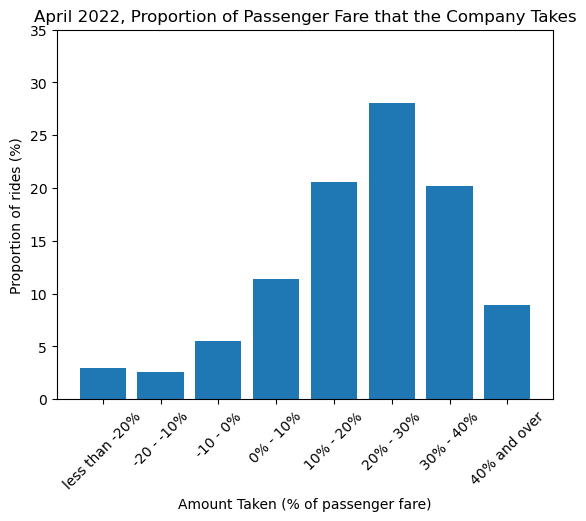

In [22]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(x = bin_labels, height = rides2022.groupby("perc_uber_takes_range")["perc_uber_takes_range"].count()*100/len(rides2022["perc_uber_takes_range"]))
ax.set_ylim(0, 35)
ax.set_xlabel('Amount Taken (% of passenger fare)')
ax.xaxis.set_tick_params(rotation=45)
ax.set_ylabel('Proportion of rides (%)')
ax.bar_label(ax.containers[0], fmt = '%.1f', label_type='edge')
ax.margins(y=0.1)
ax.set_title('April 2022, Proportion of Passenger Fare that the Company Takes')

## Losses on rides

#### Distribution of the percentage losses taken (among rides where a loss was taken)

In [13]:
rides2022[rides2022['perc_uber_takes'] < 0]['perc_uber_takes'].describe()

count   1843917.00000
mean         -0.20706
std           2.39242
min       -1682.00000
25%          -0.21231
50%          -0.10056
75%          -0.04111
max          -0.00010
Name: perc_uber_takes, dtype: float64

#### Distribution of the percentage made over the minimum rate (among rides where a loss was taken)

In [14]:
rides2022[rides2022['perc_uber_takes'] < 0]['perc_over_min_rate'].describe()

count   1843917.00000
mean          0.66963
std           3.22425
min          -0.90718
25%           0.02577
50%           0.22173
75%           0.82466
max        3272.78962
Name: perc_over_min_rate, dtype: float64

In [18]:
rides2022[(rides2022['perc_uber_takes'] < 0) & (rides2022['perc_over_min_rate'] < 0)]['perc_over_min_rate'].describe()

count   31717.00000
mean       -0.01463
std         0.08321
min        -0.90718
25%        -0.00023
50%        -0.00010
75%        -0.00004
max        -0.00000
Name: perc_over_min_rate, dtype: float64

In [19]:
rides2022[(rides2022['perc_uber_takes'] < 0) & (rides2022['perc_over_min_rate'] < 0)]['over_min_rate'].describe()

count   31717.00000
mean       -0.60355
std         4.44481
min      -136.72284
25%        -0.00445
50%        -0.00242
75%        -0.00106
max        -0.00000
Name: over_min_rate, dtype: float64

#### Distribution of the dollar amount made over the minimum rate (among rides where a loss was taken)

In [16]:
rides2022[rides2022['perc_uber_takes'] < 0]['over_min_rate'].describe()

count   1843917.00000
mean          5.06736
std           6.30676
min        -136.72284
25%           0.67400
50%           2.97089
75%           7.04469
max         137.86872
Name: over_min_rate, dtype: float64

#### Distribution of the percentage made over the minimum rate (among rides where a loss was not taken)

In [17]:
rides2022[rides2022['perc_uber_takes'] >= 0]['perc_over_min_rate'].describe()

count   15110630.00000
mean           0.26351
std            1.17701
min           -0.99874
25%            0.00463
50%            0.06784
75%            0.27141
max         1140.42944
Name: perc_over_min_rate, dtype: float64

#### Distribution of the dollar amount made over the minimum rate (among rides where a loss was not taken)

In [ ]:
rides2022[rides2022['perc_uber_takes'] >= 0]['over_min_rate'].describe()

#### Percentage of rides that made under the minimum rate when a loss was taken

In [ ]:
len(rides2022[(rides2022['perc_uber_takes'] < 0) & (rides2022['perc_over_min_rate'] < 0)]['perc_over_min_rate'])/ len(rides2022[rides2022['perc_uber_takes'] < 0]['perc_over_min_rate'])

## Trip lengths

In [ ]:
rides2022["trip_time_min"].describe()

In [ ]:
rides2022["trip_miles"].describe()